# Make forword Model
MNE document site:https://mne.tools/1.8/auto_tutorials/forward/35_eeg_no_mri.html

### Adult template MRI (fsaverage)
- [ ] Check the source model
- [ ] Check the BEM model

By default, the condutivity of BEM model is [0.3, 0.006, 0.3] for [brain, skull, scalp]

In [1]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Joan Massich <mailsik@gmail.com>
#          Eric Larson <larson.eric.d@gmail.com>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

import numpy as np

import mne
from mne.datasets import eegbci, fetch_fsaverage, sample

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = fs_dir

# The files live in:
subject = "fsaverage"
trans = "fsaverage"  # MNE has a built-in fsaverage transformation
src = fs_dir / "bem" / "fsaverage-ico-5-src.fif"
bem = fs_dir / "bem" / "fsaverage-5120-5120-5120-bem-sol.fif"


0 files missing from root.txt in C:\Users\richi\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage


## Load Data

In [2]:
(raw_fname,) = eegbci.load_data(subject=1, runs=[6])
raw = mne.io.read_raw_edf(raw_fname, preload=True)

# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name, ch_name.rstrip(".").upper().replace("Z", "z").replace("FP", "Fp"))
    for ch_name in raw.ch_names
)
raw.rename_channels(new_names)

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)  # needed for inverse modeling

# Check that the locations of EEG electrodes is correct with respect to MRI
mne.viz.plot_alignment(
    raw.info,
    src=src,
    eeg=["original", "projected"],
    trans=trans,
    show_axes=True,
    mri_fiducials=True,
    dig="fiducials",
)

Extracting EDF parameters from C:\Users\richi\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Reading C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Using notebook 3d backend.
Using outer_skin.surf for head surface.
Channel types::	eeg: 64
Projecting sensors to the head surface


## Setup source space and compute forward

In [5]:
fwd = mne.make_forward_solution(
    raw.info, trans=trans, src=src, bem=bem, eeg=True, mindist=5.0, n_jobs=None
)
print(fwd)

Source space          : C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif
MRI -> head transform : c:\Users\richi\anaconda3\envs\lab-work\Lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Read 2 source spaces a total of 20484 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999994 0.003552 0.000202      -1.76 mm
    -0.003558 0.998389 0.056626      31.09 mm
    -0.000001 -0.056626 0.998395      39.60 mm
    0.000000 0.000000 0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM mode

##### Structure of fwd

In [21]:
leadfield = fwd["sol"]["data"]
print(f"Leadfield size : {leadfield.shape[0]} sensors x {leadfield.shape[1]} dipoles")

Leadfield size : 64 sensors x 61452 dipoles


##### Source coordinate

In [22]:
fwd_src = fwd['src']
fwd_src

<SourceSpaces: [<surface (lh), n_vertices=163842, n_used=10242>, <surface (rh), n_vertices=163842, n_used=10242>] head coords, subject 'fsaverage', ~25.6 MB>

In [ ]:
print(len(fwd_src[0]['rr']))
print(len(fwd_src[0]['rr'][fwd_src[0]['inuse'] == 1]))
fwd_src[0]['rr'][fwd_src[0]['inuse'] == 1]


163842
10242


array([[-0.03862072,  0.01661226,  0.10499121],
       [-0.01817344, -0.03212844,  0.10247761],
       [-0.01327658,  0.02615479,  0.0872164 ],
       ...,
       [-0.03184567,  0.00518414,  0.01609419],
       [-0.03390351,  0.00590186,  0.01751144],
       [-0.03572476,  0.00585851,  0.01883127]])

In [51]:
labels = mne.read_labels_from_annot("", subjects_dir=subjects_dir)
data_path = sample.data_path(download=False)
print(f"Total vertices in labels: {sum([label.__len__() for label in labels])}")
labels

Reading labels from parcellation...
   read 35 labels from C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\label\lh.aparc.annot
   read 34 labels from C:\Users\richi\mne_data\MNE-fsaverage-data\fsaverage\label\rh.aparc.annot
Total vertices in labels: 299881


[<Label | , 'bankssts-lh', lh : 2137 vertices>,
 <Label | , 'bankssts-rh', rh : 2196 vertices>,
 <Label | , 'caudalanteriorcingulate-lh', lh : 1439 vertices>,
 <Label | , 'caudalanteriorcingulate-rh', rh : 1608 vertices>,
 <Label | , 'caudalmiddlefrontal-lh', lh : 3736 vertices>,
 <Label | , 'caudalmiddlefrontal-rh', rh : 3494 vertices>,
 <Label | , 'cuneus-lh', lh : 1630 vertices>,
 <Label | , 'cuneus-rh', rh : 1638 vertices>,
 <Label | , 'entorhinal-lh', lh : 1102 vertices>,
 <Label | , 'entorhinal-rh', rh : 902 vertices>,
 <Label | , 'frontalpole-lh', lh : 272 vertices>,
 <Label | , 'frontalpole-rh', rh : 369 vertices>,
 <Label | , 'fusiform-lh', lh : 4714 vertices>,
 <Label | , 'fusiform-rh', rh : 4661 vertices>,
 <Label | , 'inferiorparietal-lh', lh : 7871 vertices>,
 <Label | , 'inferiorparietal-rh', rh : 9676 vertices>,
 <Label | , 'inferiortemporal-lh', lh : 4415 vertices>,
 <Label | , 'inferiortemporal-rh', rh : 4198 vertices>,
 <Label | , 'insula-lh', lh : 5229 vertices>,
 <L

In [ ]:
raw.info['chs']
"""
loc[:3] is the location of channels.
loc[3:6] is the contain the reference channel postion. Raw只是container. Made by set_montage沒有真正的eeg data, no reference.
"""

[{'cal': 1.0,
  'logno': 1,
  'scanno': 1,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'FC5',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([-0.07890598,  0.05136738,  0.06296235,  0.        ,  0.        ,
          0.        ,         nan,         nan,         nan,         nan,
                 nan,         nan])},
 {'cal': 1.0,
  'logno': 2,
  'scanno': 2,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'FC3',
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'kind': 2 (FIFFV_EEG_CH),
  'loc': array([-0.06185234,  0.05713329,  0.09376583,  0.        ,  0.        ,
          0.        ,         nan,         nan,         nan,         nan,
                 nan,         nan])},
 {'cal': 1.0,
  'logno': 3,
  'scanno': 3,
  'range': 1.0,
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'ch_name': 'FC1',
  'unit': 

In [ ]:
events = np.array([[  0,   0,   1],
                  [200,   0,   2]])
mne.write_events('./_0-1_200-2_eve.fif', events=events, overwrite=True)

## Harmonic Function

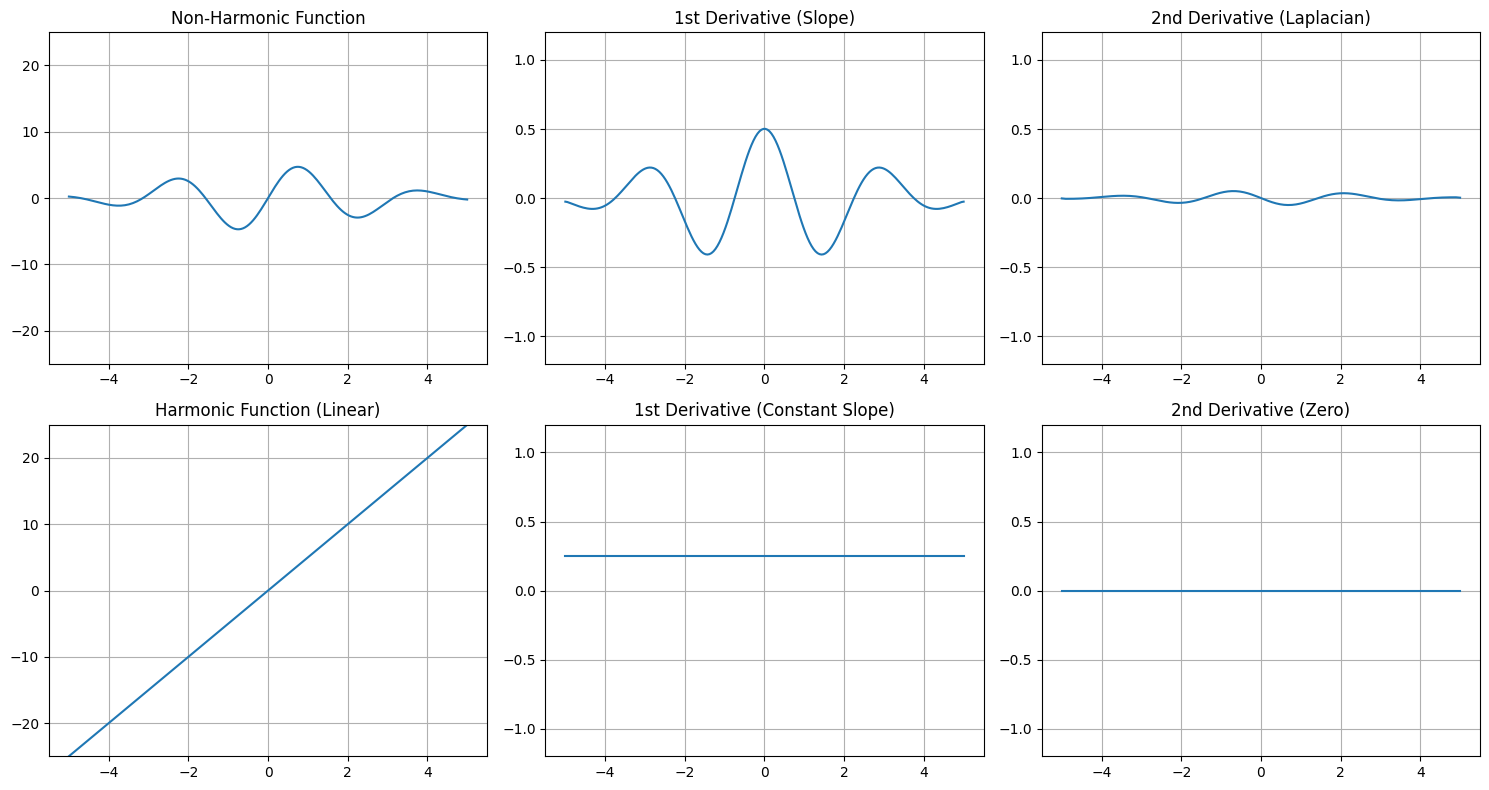

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the domain
x = np.linspace(-5, 5, 200)

# Function 1: Non-harmonic, with large second derivative (e.g., a sharp curve)
f1 = 5 * np.exp(-0.1 * x**2) * np.sin(2 * x)
f1_dx = np.gradient(f1)       # First derivative
f1_d2x = np.gradient(f1_dx)   # Second derivative

# Function 2: Harmonic function (Laplace operator = 0), e.g., linear function
f2 = 5 * x                   # Large slope, but constant
f2_dx = np.gradient(f2)
f2_d2x = np.gradient(f2_dx)

# Set common y-limits for comparison
y_limits = {
    "f1": (-25, 25),
    "f1_dx": (-1.2, 1.2),
    "f1_d2x": (-1.2, 1.2),
    "f2": (-25, 25),
    "f2_dx": (-1.2, 1.2),
    "f2_d2x":(-1.2, 1.2),
}

# Plotting with fixed y-limits
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Plot function 1 (non-harmonic)
axs[0, 0].plot(x, f1)
axs[0, 0].set_ylim(y_limits["f1"])
axs[0, 0].set_title("Non-Harmonic Function")

axs[0, 1].plot(x, f1_dx)
axs[0, 1].set_ylim(y_limits["f1_dx"])
axs[0, 1].set_title("1st Derivative (Slope)")

axs[0, 2].plot(x, f1_d2x)
axs[0, 2].set_ylim(y_limits["f1_d2x"])
axs[0, 2].set_title("2nd Derivative (Laplacian)")

# Plot function 2 (harmonic)
axs[1, 0].plot(x, f2)
axs[1, 0].set_ylim(y_limits["f2"])
axs[1, 0].set_title("Harmonic Function (Linear)")

axs[1, 1].plot(x, f2_dx)
axs[1, 1].set_ylim(y_limits["f2_dx"])
axs[1, 1].set_title("1st Derivative (Constant Slope)")

axs[1, 2].plot(x, f2_d2x)
axs[1, 2].set_ylim(y_limits["f2_d2x"])
axs[1, 2].set_title("2nd Derivative (Zero)")

# Add grid
for ax_row in axs:
    for ax in ax_row:
        ax.grid(True)

plt.tight_layout()
plt.show()